In [1]:
import pandas as pd
import numpy as np

from time import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as py

py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

from IPython.display import Markdown, display
import warnings

warnings.filterwarnings("ignore")

pip install 'aif360[LawSchoolGPA]'
2022-12-19 23:47:24.269851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 23:47:24.747763: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-19 23:47:24.747790: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-19 23:47:27.641040: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object fi

# 1- Loading the data

In [2]:
data = pd.read_csv('data/homicide_reports.csv', na_values=['Unknown', ' '])

# 2- EDA

In [3]:
data.shape

(638454, 24)

In [4]:
data.head().T

,0,1,2,3,4
Record ID,1,2,3,4,5
Agency Code,AK00101,AK00101,AK00101,AK00101,AK00101
Agency Name,Anchorage,Anchorage,Anchorage,Anchorage,Anchorage
Agency Type,Municipal Police,Municipal Police,Municipal Police,Municipal Police,Municipal Police
City,Anchorage,Anchorage,Anchorage,Anchorage,Anchorage
State,Alaska,Alaska,Alaska,Alaska,Alaska
Year,1980,1980,1980,1980,1980
Month,January,March,March,April,April
Incident,1,1,2,1,2
Crime Type,Murder or Manslaughter,Murder or Manslaughter,Murder or Manslaughter,Murder or Manslaughter,Murder or Manslaughter


In [5]:
columns_for_drop = ['Record ID', 'Agency Code', 'Perpetrator Ethnicity']
data_orig = data.copy()
data.drop(columns=columns_for_drop, inplace=True)
columns_for_drop = []

# 3- Missing values

In [6]:
def print_missing_values(data):
    data_null = pd.DataFrame(len(data) - data.notnull().sum(), columns=['Count'])
    data_null = data_null[data_null['Count'] > 0].sort_values(by='Count', ascending=False)
    data_null = data_null / len(data) * 100

    trace = go.Bar(x=data_null.index, y=data_null['Count'], marker=dict(color='#c0392b'),
                   name='At least one missing value', opacity=0.9)
    layout = go.Layout(barmode='group', title='Column with missing values in the dataset', showlegend=True,
                       legend=dict(orientation="h"), yaxis=dict(title='Percentage of the dataset'))
    fig = go.Figure([trace], layout=layout)
    py.iplot(fig)

In [7]:
print('Number total of rows : ' + str(data.shape[0]))
print_missing_values(data)

Number total of rows : 638454


# 4- Solve and Unsolved

In [8]:
data['Crime Solved'].value_counts()

Yes    448172
No     190282
Name: Crime Solved, dtype: int64

In [9]:
data_orig = data.copy()
data = data[data['Crime Solved'] == 'Yes']
columns_for_drop += ['Crime Solved']

# 5- Categorize Age

In [10]:
data['Perpetrator Age category'] = np.where(data['Perpetrator Age'] > 64, 'Elder',
                                            np.where(data['Perpetrator Age'] < 25, 'Young', 'Adult'))

In [11]:
Y_columns = ['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category']
ignore_columns = ['Crime Solved']
cat_columns = []
num_columns = []

for col in data.columns.values:
    if col in Y_columns + ignore_columns:
        continue
    elif data[col].dtypes == 'int64':
        num_columns += [col]
    else:
        cat_columns += [col]


# 6- Finding Median Value

In [12]:
median_val = pd.Series()
for col in num_columns:
    if col not in columns_for_drop:
        median_val[col] = data[col].median()

In [13]:
median_val

Year                 1995.0
Incident                2.0
Victim Age             30.0
Victim Count            0.0
Perpetrator Count       0.0
dtype: float64

# 7- Handling Missing Values

In [14]:
def handle_missing_values(data, median_val):
    df = data.copy()
    for col in df:
        if col in median_val.index.values:
            df[col] = df[col].fillna(median_val[col])
        else:
            df[col] = df[col].fillna("Missing value")

    return df

In [15]:
data = handle_missing_values(data, median_val)

# 8- Visualization

In [16]:
def target_distribution(y_var, data):
    val = data[y_var]

    plt.style.use('seaborn-whitegrid')
    plt.rcParams.update({'font.size': 13})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    cnt = val.value_counts().sort_values(ascending=True)
    labels = cnt.index.values

    sizes = cnt.values
    colors = sns.color_palette("PuBu", len(labels))

    ax1.barh(cnt.index.values, cnt.values, color=colors)
    ax1.set_title('Count plot of ' + y_var)

    ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', shadow=True, startangle=130)
    ax2.axis('equal')
    ax2.set_title('Distribution of ' + y_var)
    plt.show()

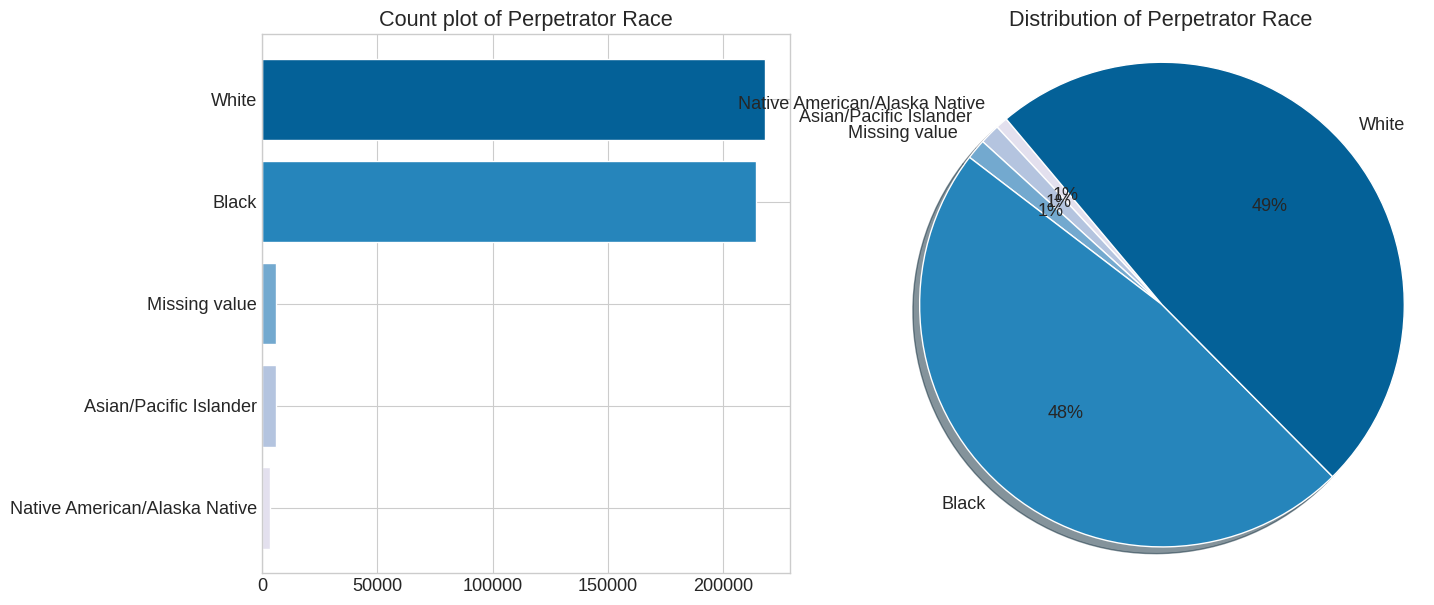

In [17]:
var = 'Perpetrator Race'
target_distribution(y_var=var, data=data)

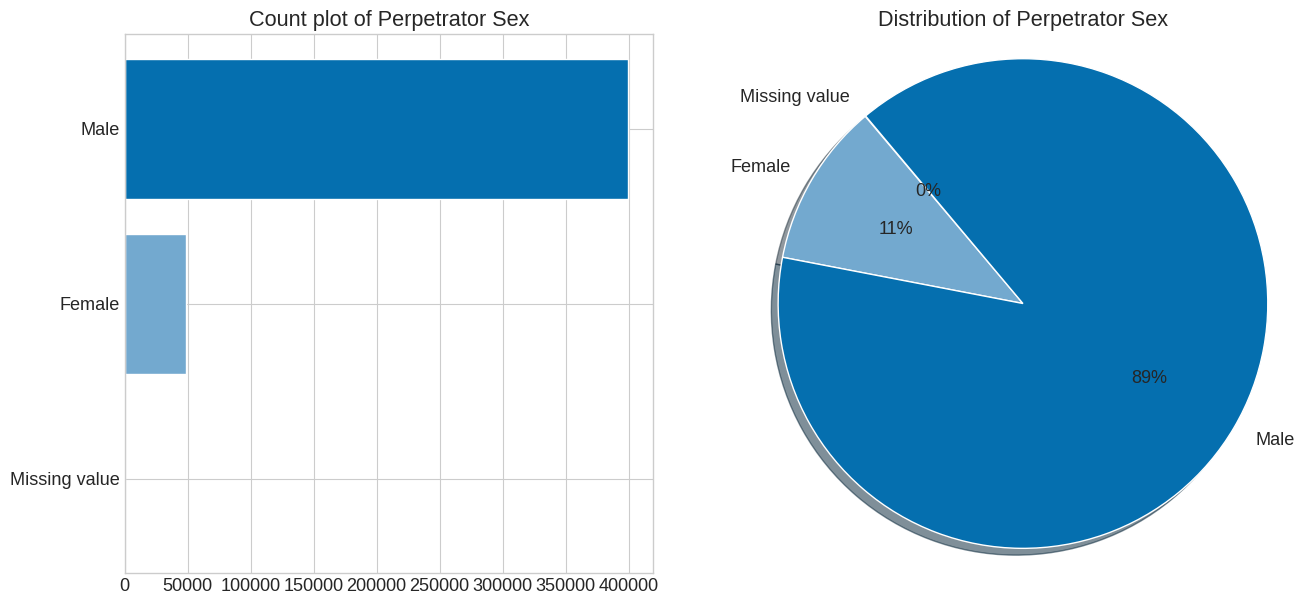

In [18]:
var = 'Perpetrator Sex'
target_distribution(y_var=var, data=data)

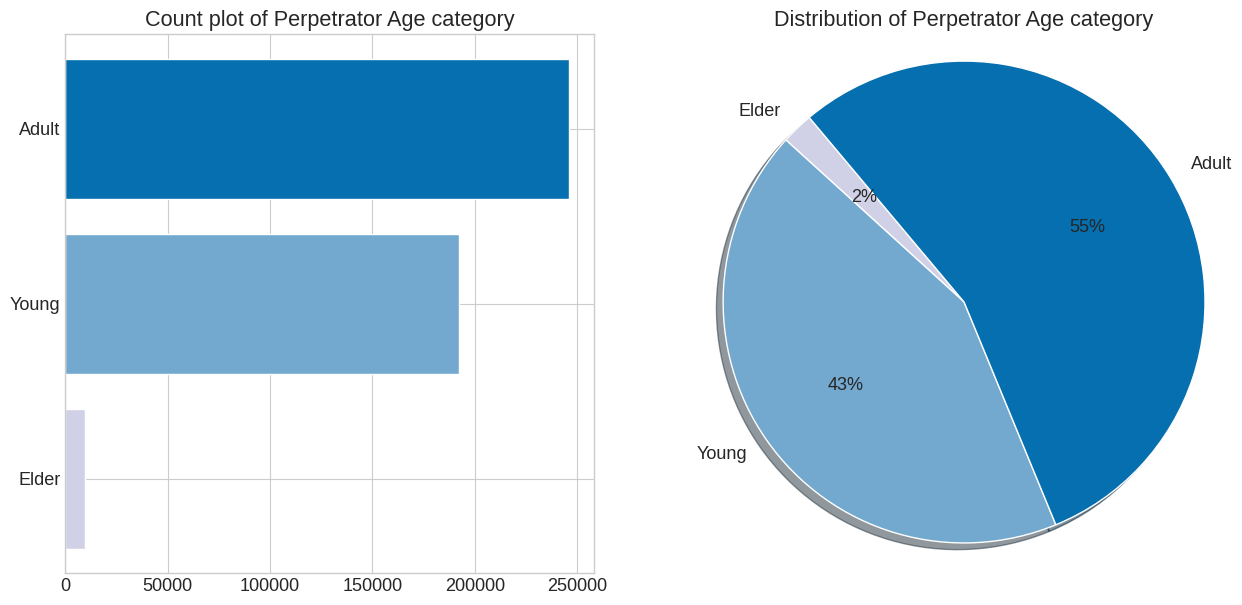

In [19]:
var = 'Perpetrator Age category'
target_distribution(y_var=var, data=data)

In [20]:
data['Frequency'] = 1
freq_target = data[['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category', 'Frequency']]
del data['Frequency']
freq_target = freq_target.groupby(by=['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category']).count() / len(
    data)
print(freq_target.sort_values(by='Frequency', ascending=False))

                                                                        Frequency
Perpetrator Sex Perpetrator Race              Perpetrator Age category           
Male            White                         Adult                      0.264265
                Black                         Young                      0.220366
                                              Adult                      0.197418
                White                         Young                      0.159222
Female          Black                         Adult                      0.035841
                White                         Adult                      0.034741
                Black                         Young                      0.018415
                White                         Young                      0.013767
Male            White                         Elder                      0.013439
                Missing value                 Young                      0.008546
                

In [21]:
def plot_histo(data, col, Y_columns):
    df = data.copy()
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    for i in range(0, 2):
        cnt = [];
        y_col = Y_columns[i]
        Y_values = df[y_col].dropna().drop_duplicates().values
        for val in Y_values:
            cnt += [df[df[y_col] == val][col].values]
        bins = df[col].nunique()

        axs[i].hist(cnt, bins=bins, stacked=True)
        axs[i].legend(Y_values, loc='upper right')
        axs[i].set_title("Histogram of the " + col + " column by " + y_col)

    plt.show()

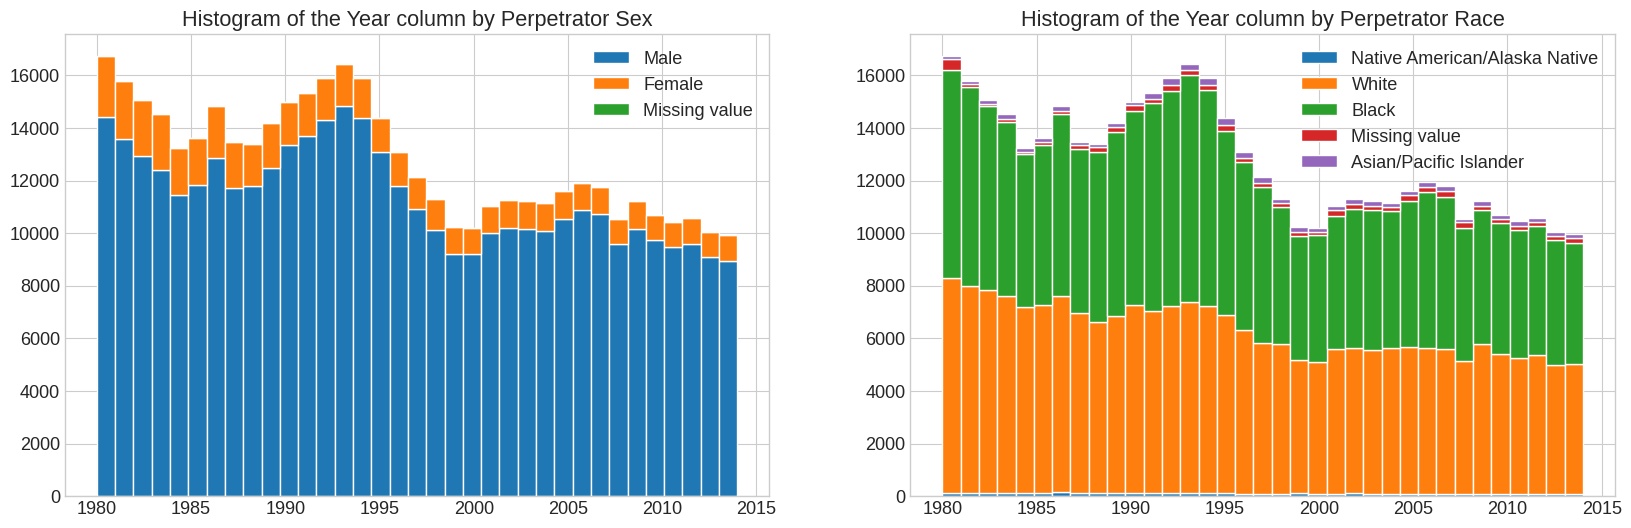

In [22]:
plot_histo(data, col='Year', Y_columns=Y_columns)

In [23]:
columns_for_drop += ['Incident']

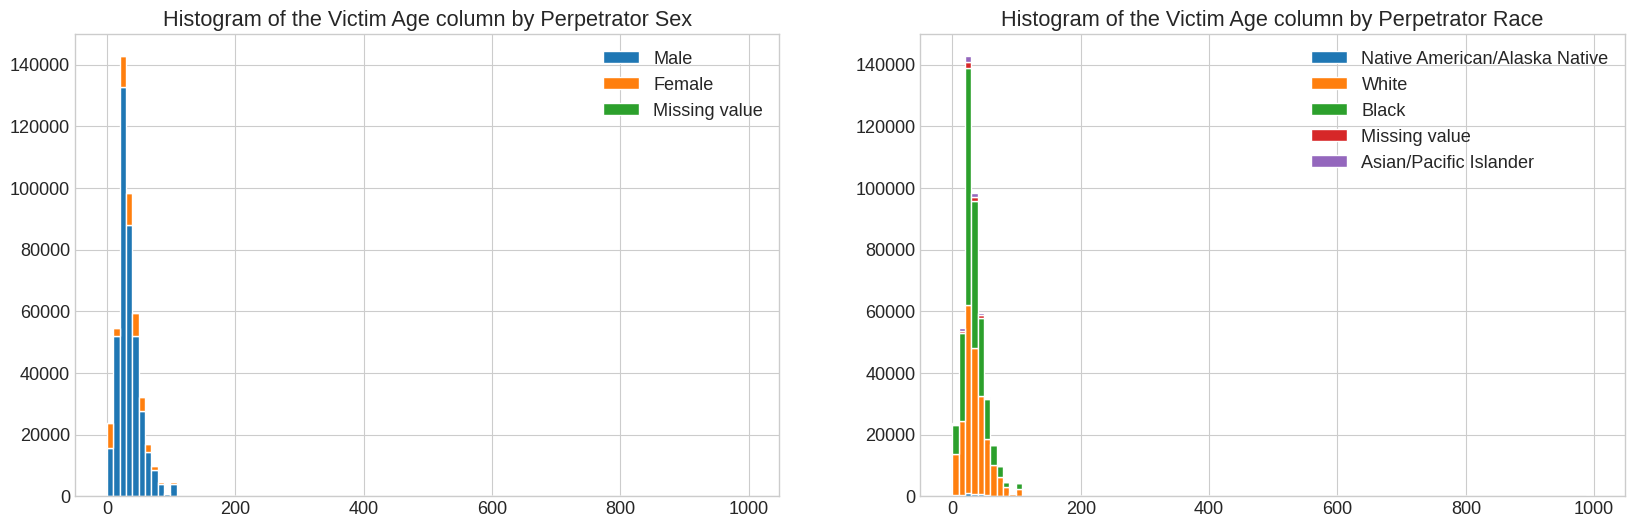

In [24]:
plot_histo(data, col='Victim Age', Y_columns=Y_columns)

In [25]:
data[data['Victim Age'] > 100]['Victim Age'].value_counts()

998    369
Name: Victim Age, dtype: int64

In [26]:
data['Victim Age'] = np.where(data['Victim Age'] == 998, np.median(data[data['Victim Age'] <= 100]['Victim Age']),
                              data['Victim Age'])

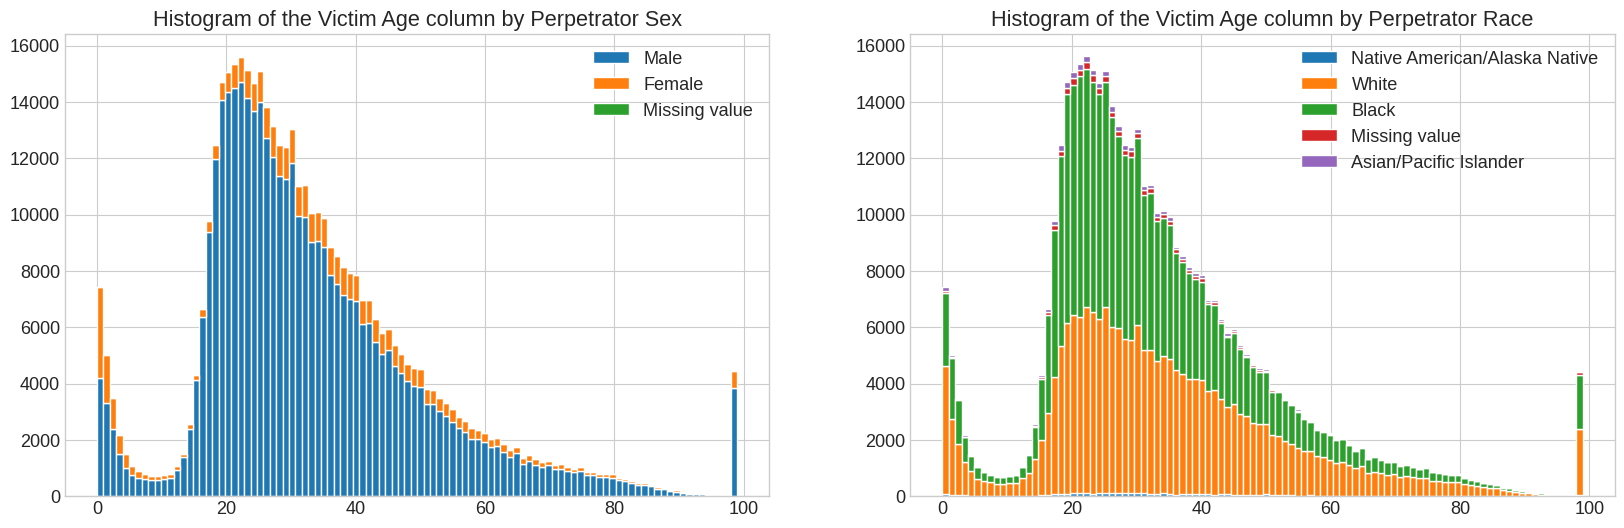

In [27]:
plot_histo(data, col='Victim Age', Y_columns=Y_columns)

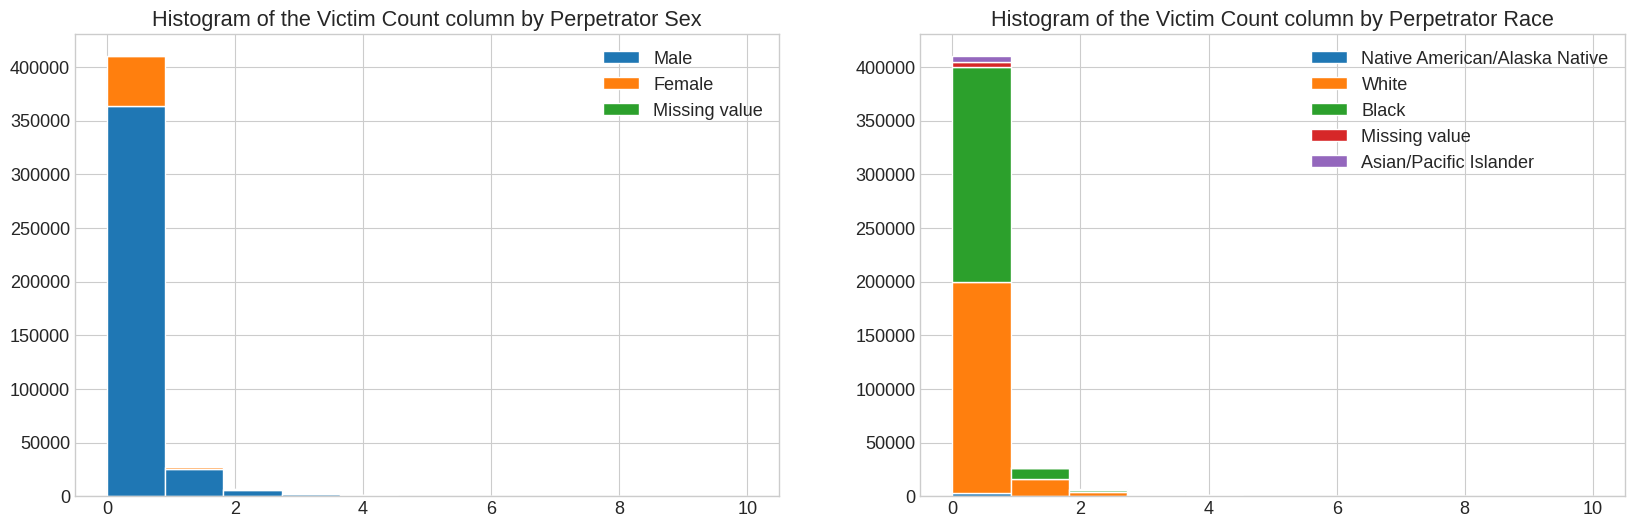

In [28]:
plot_histo(data, col='Victim Count', Y_columns=Y_columns)

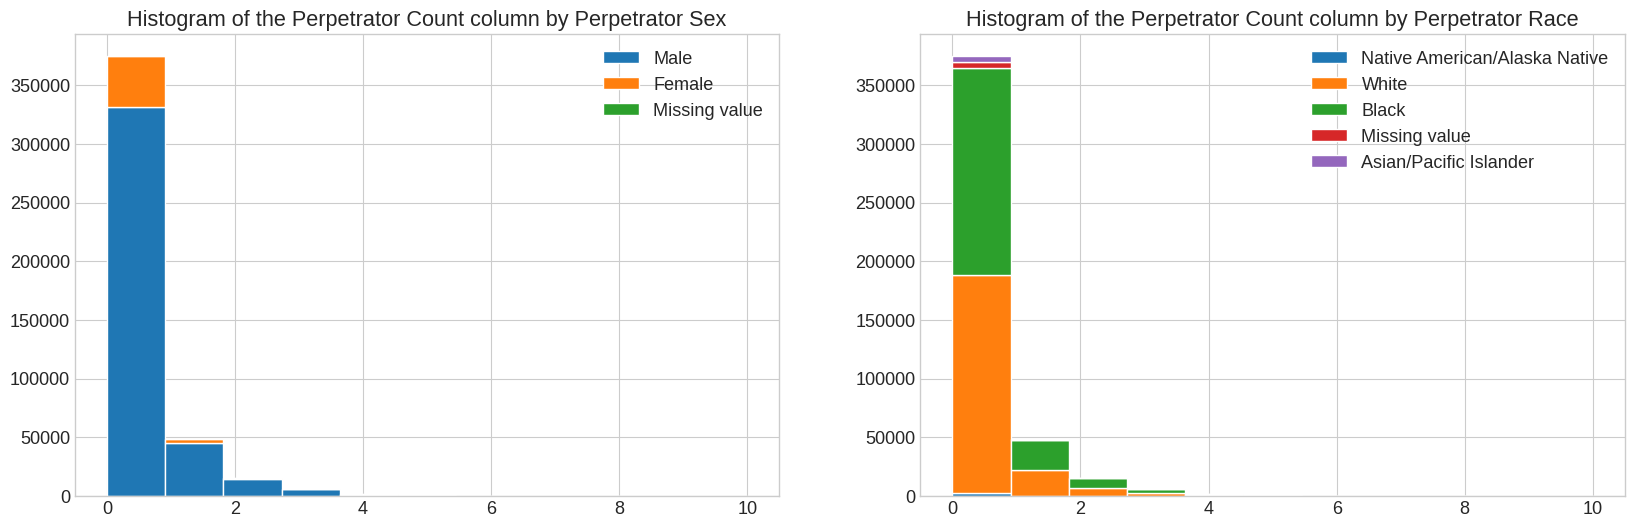

In [29]:
plot_histo(data, col='Perpetrator Count', Y_columns=Y_columns)

In [30]:
cat_columns

['Agency Name',
 'Agency Type',
 'City',
 'State',
 'Month',
 'Crime Type',
 'Victim Sex',
 'Victim Race',
 'Victim Ethnicity',
 'Perpetrator Age',
 'Relationship',
 'Weapon',
 'Record Source']

In [31]:
def plot_bar(data, col, Y_columns, max_cat=10):
    df = data.copy()

    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    cat_val = df[col].value_counts()[0:max_cat].index.values
    df = df[df[col].isin(cat_val)]

    for i in range(0, 2):
        y_col = Y_columns[i]
        Y_values = df[y_col].dropna().drop_duplicates().values
        for val in Y_values:
            cnt = df[df[y_col] == val][col].value_counts().sort_index()
            axs[i].barh(cnt.index.values, cnt.values)
        axs[i].legend(Y_values, loc='upper right')
        axs[i].set_title("Bar plot of the " + col + " column by " + y_col)

    plt.show()

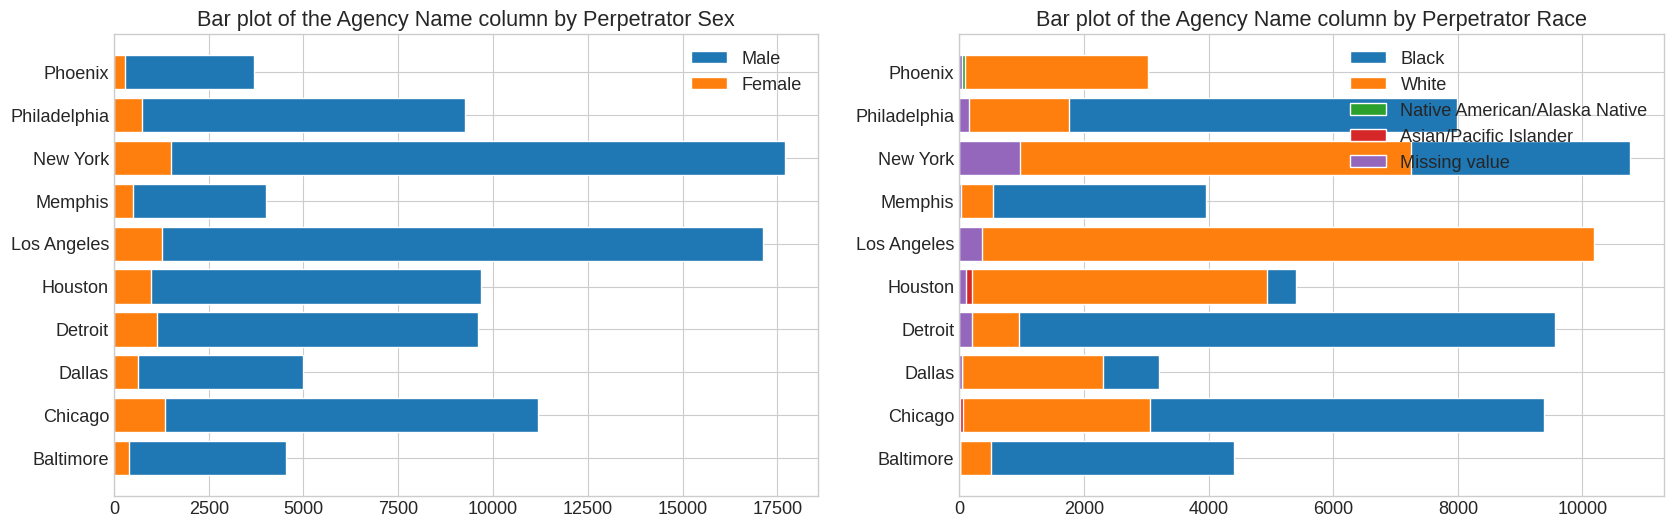

In [32]:
plot_bar(data, col='Agency Name', Y_columns=Y_columns)

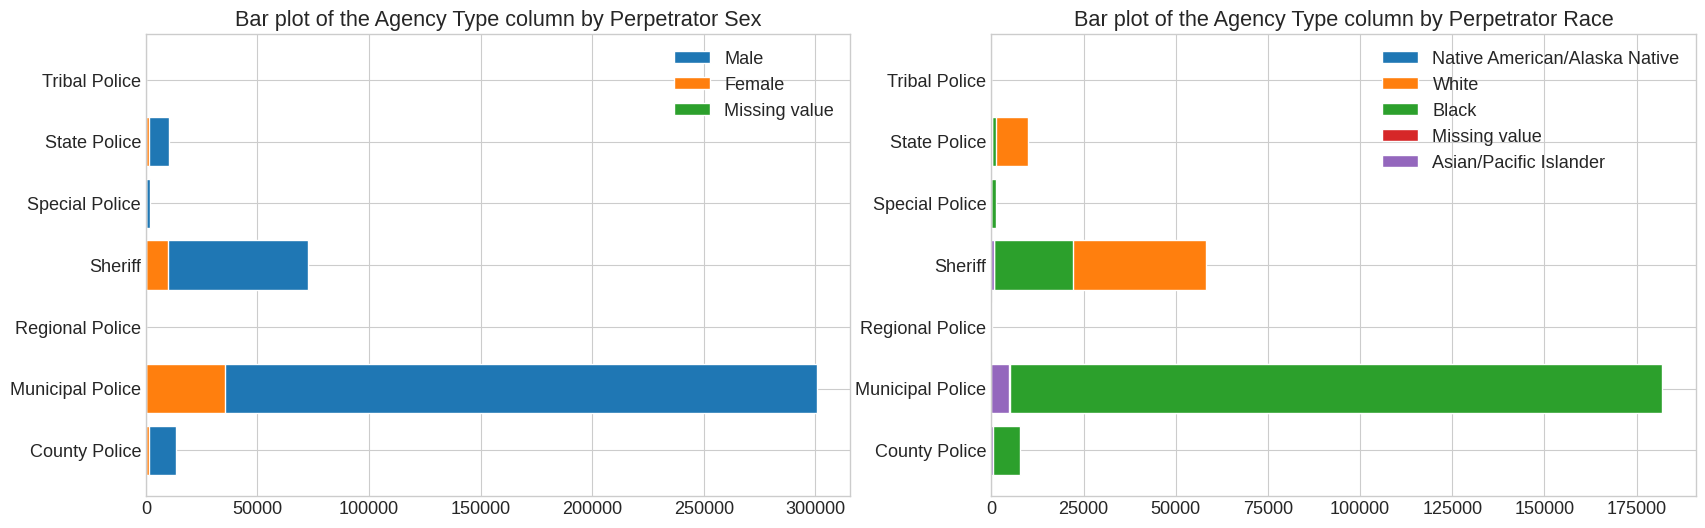

In [33]:
plot_bar(data, col='Agency Type', Y_columns=Y_columns)

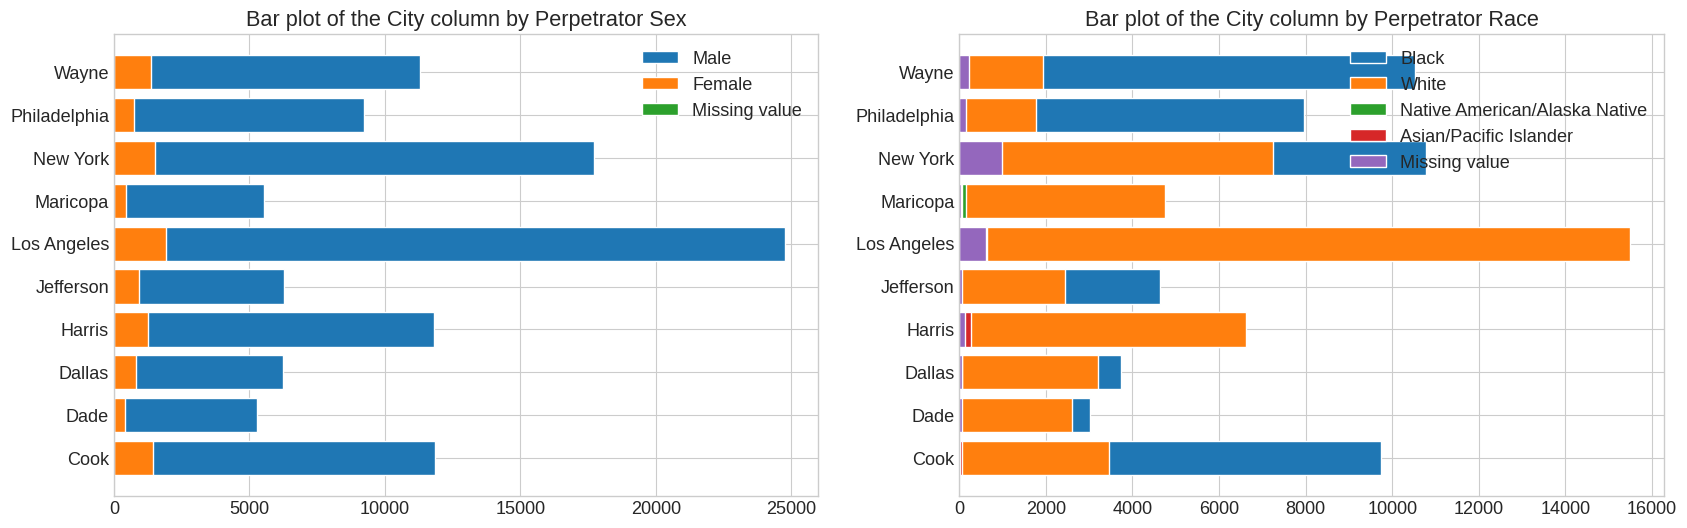

In [34]:
plot_bar(data, col='City', Y_columns=Y_columns)

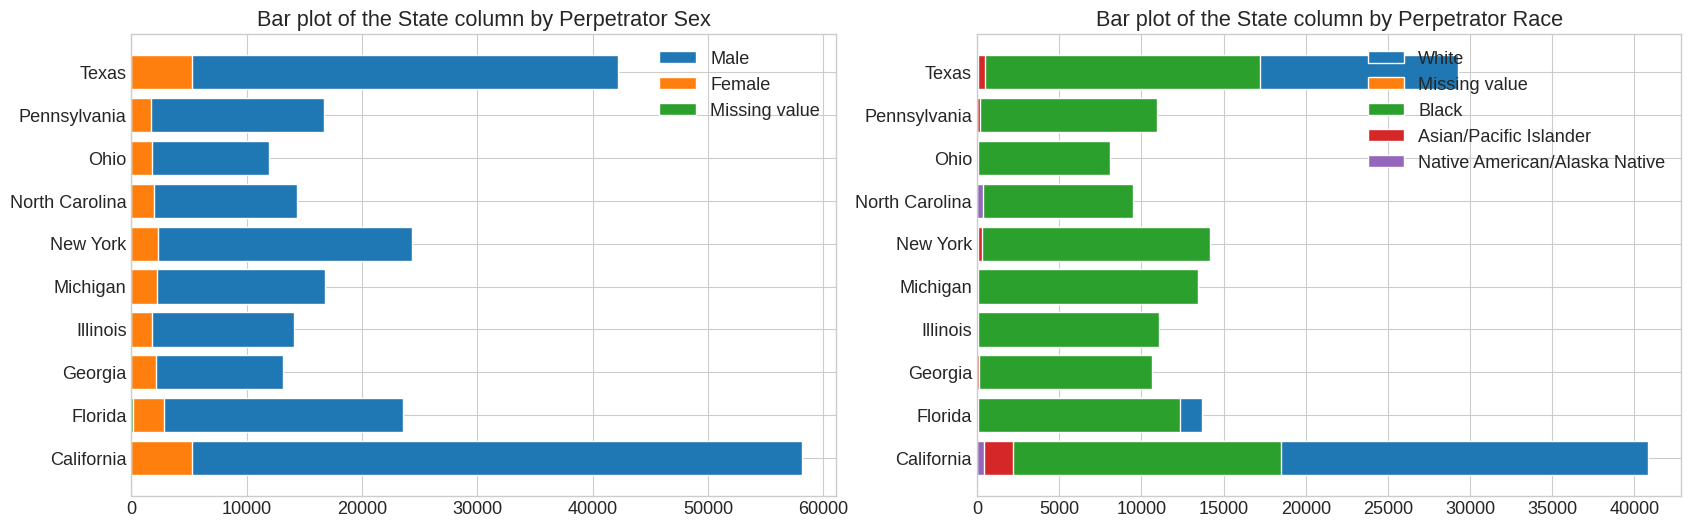

In [35]:
plot_bar(data, col='State', Y_columns=Y_columns)

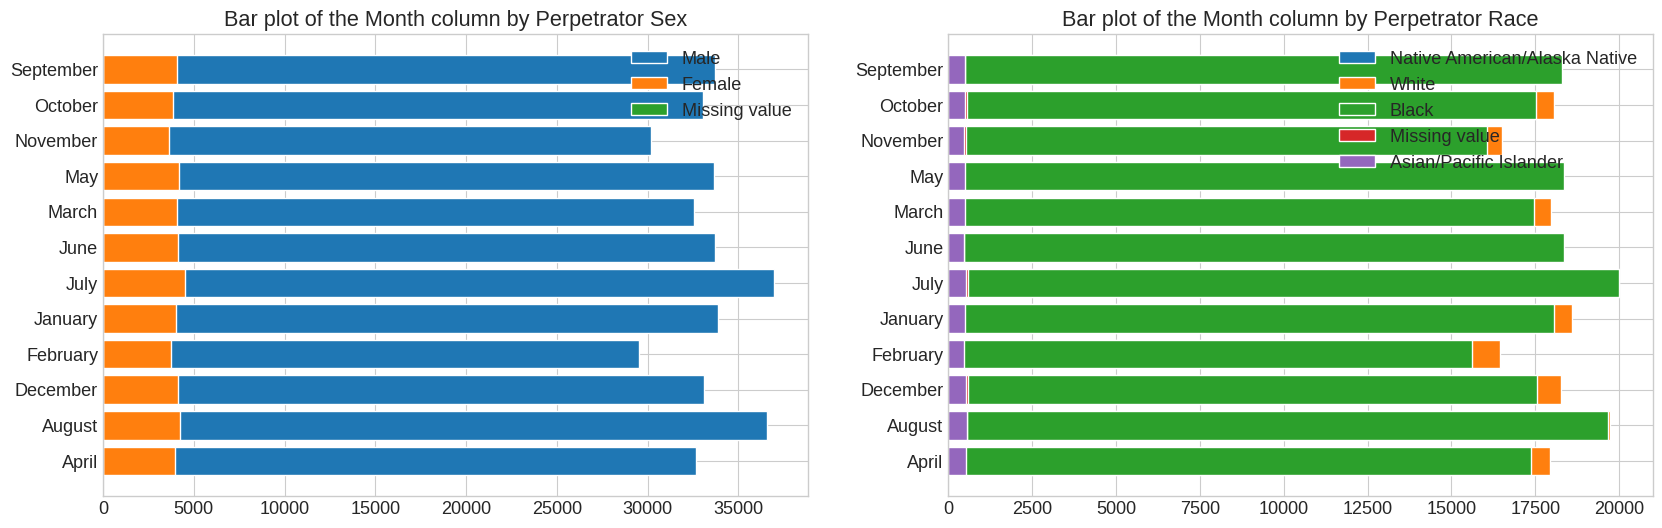

In [36]:
plot_bar(data, col='Month', Y_columns=Y_columns, max_cat=12)

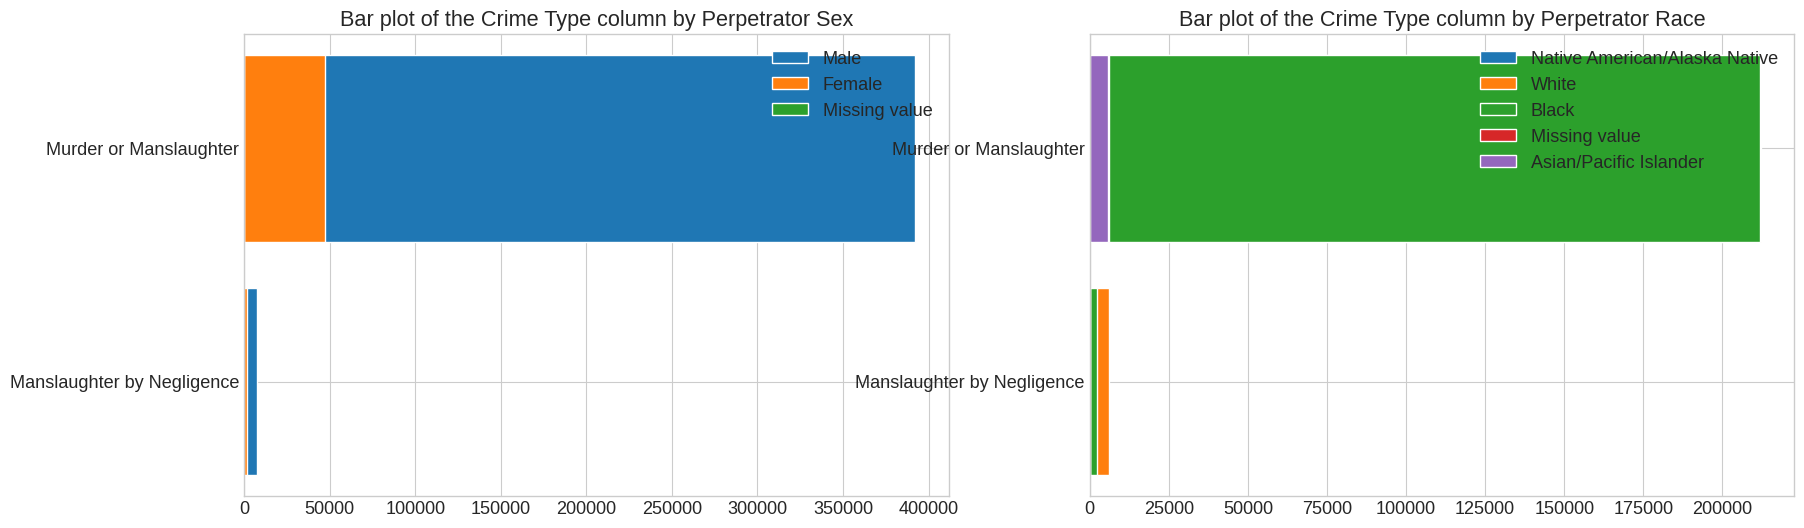

In [37]:
plot_bar(data, col='Crime Type', Y_columns=Y_columns)

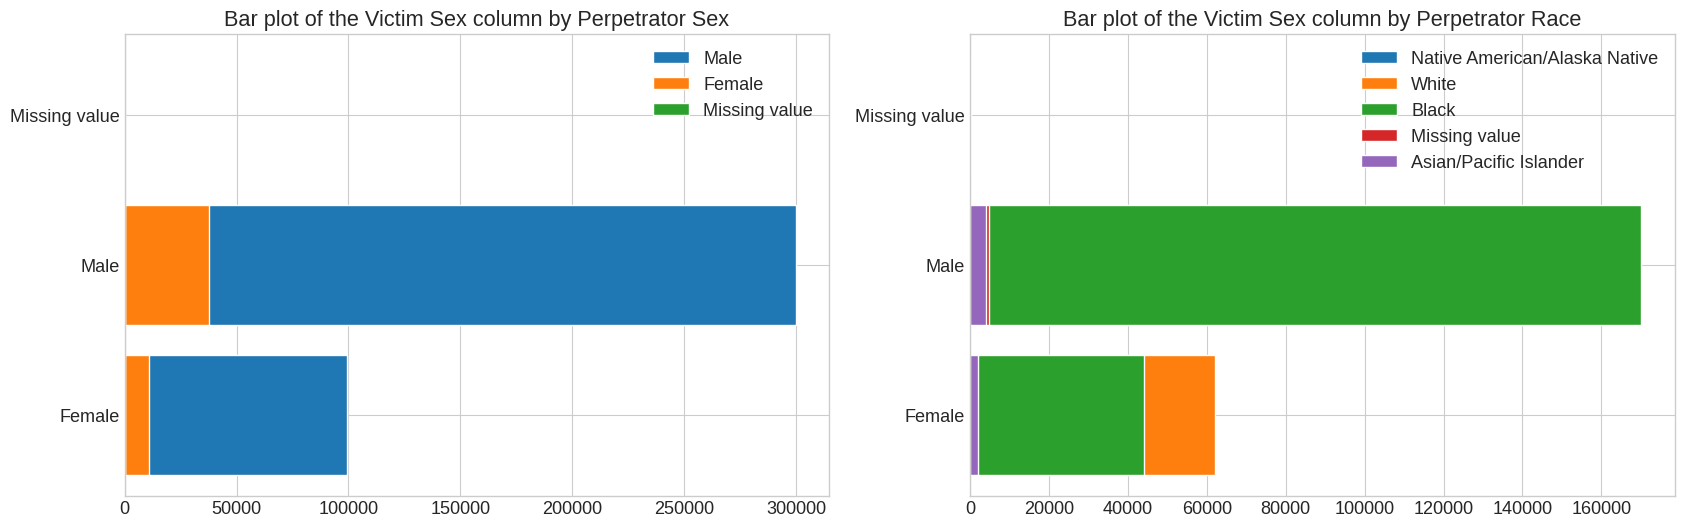

In [38]:
plot_bar(data, col='Victim Sex', Y_columns=Y_columns)

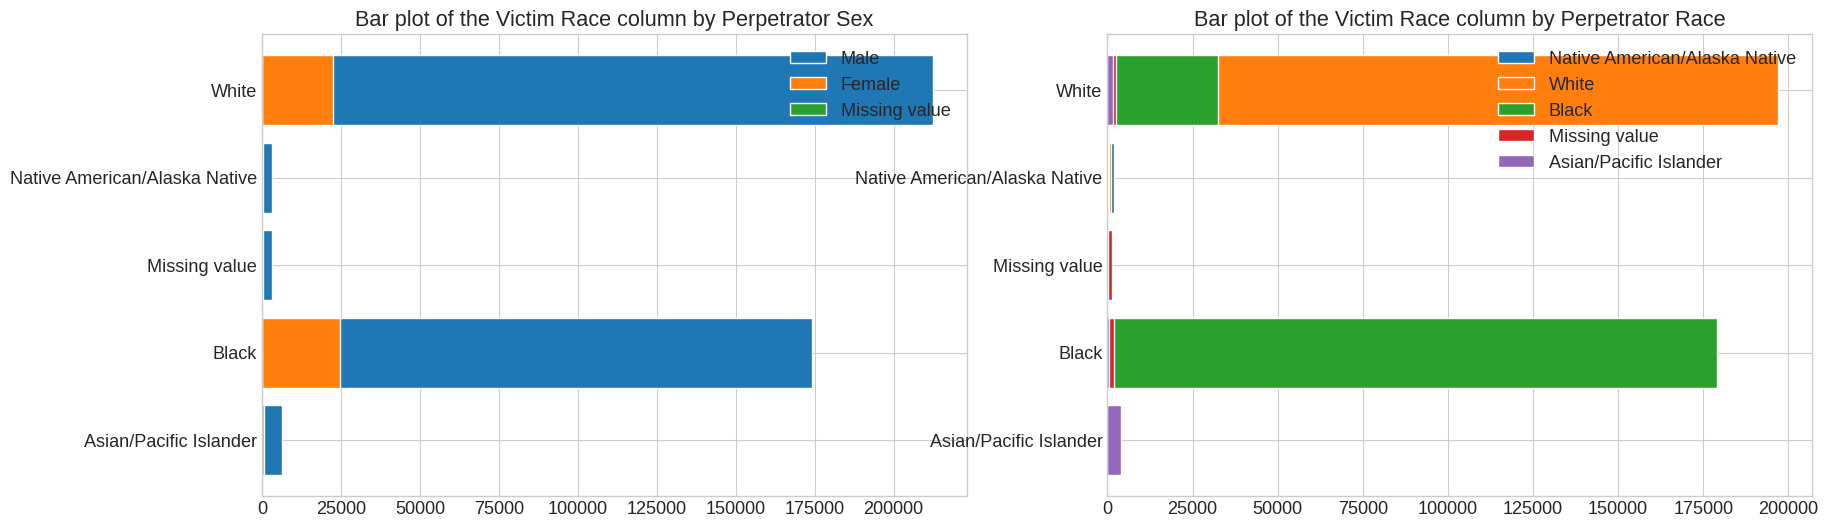

In [39]:
plot_bar(data, col='Victim Race', Y_columns=Y_columns)

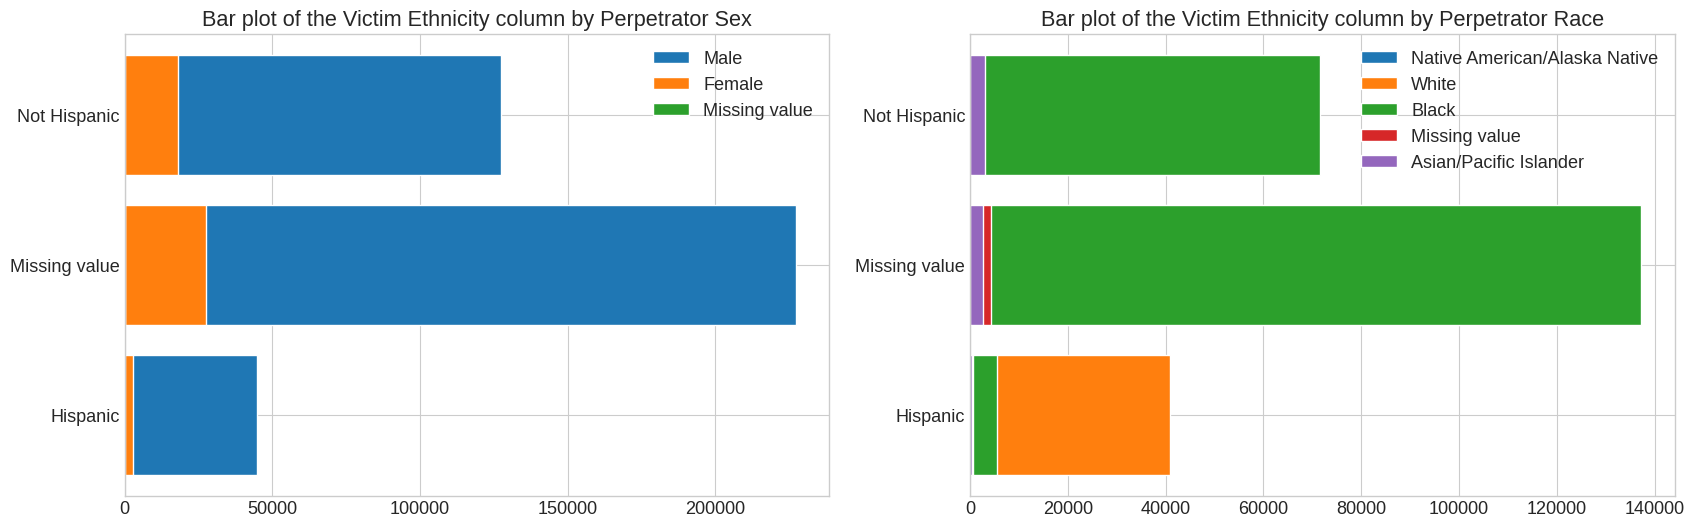

In [40]:
plot_bar(data, col='Victim Ethnicity', Y_columns=Y_columns)

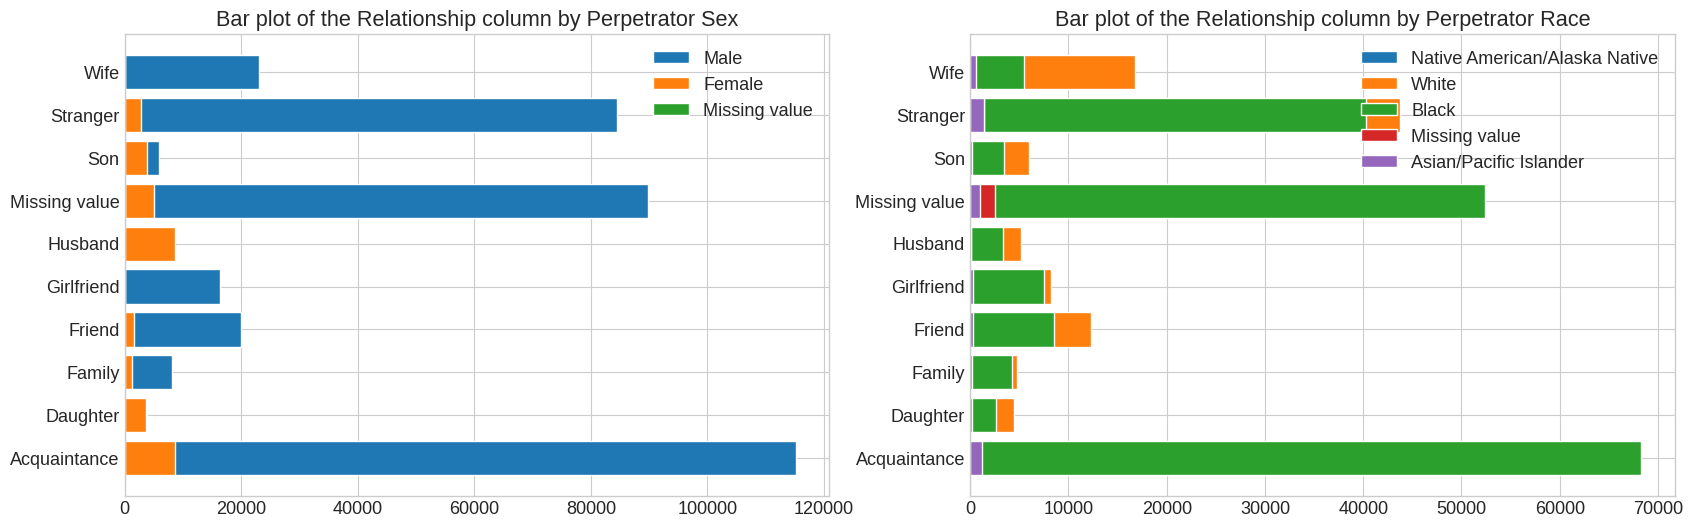

In [41]:
plot_bar(data, col='Relationship', Y_columns=Y_columns)

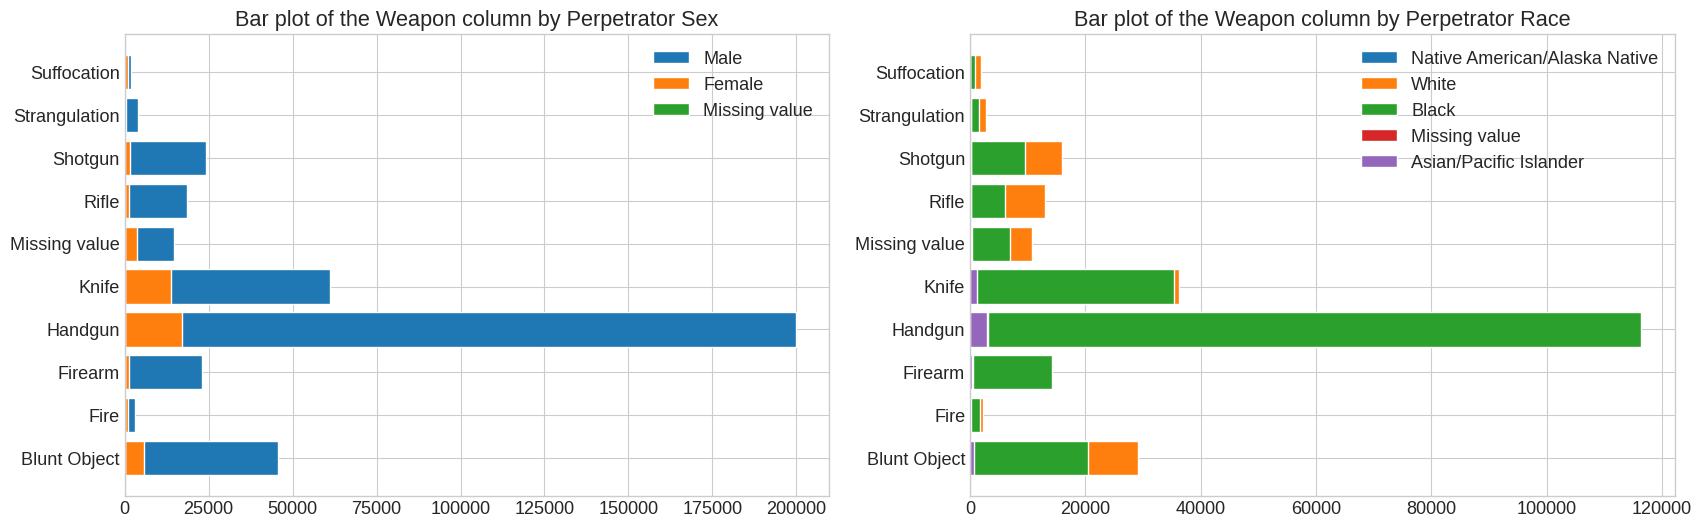

In [42]:
plot_bar(data, col='Weapon', Y_columns=Y_columns)

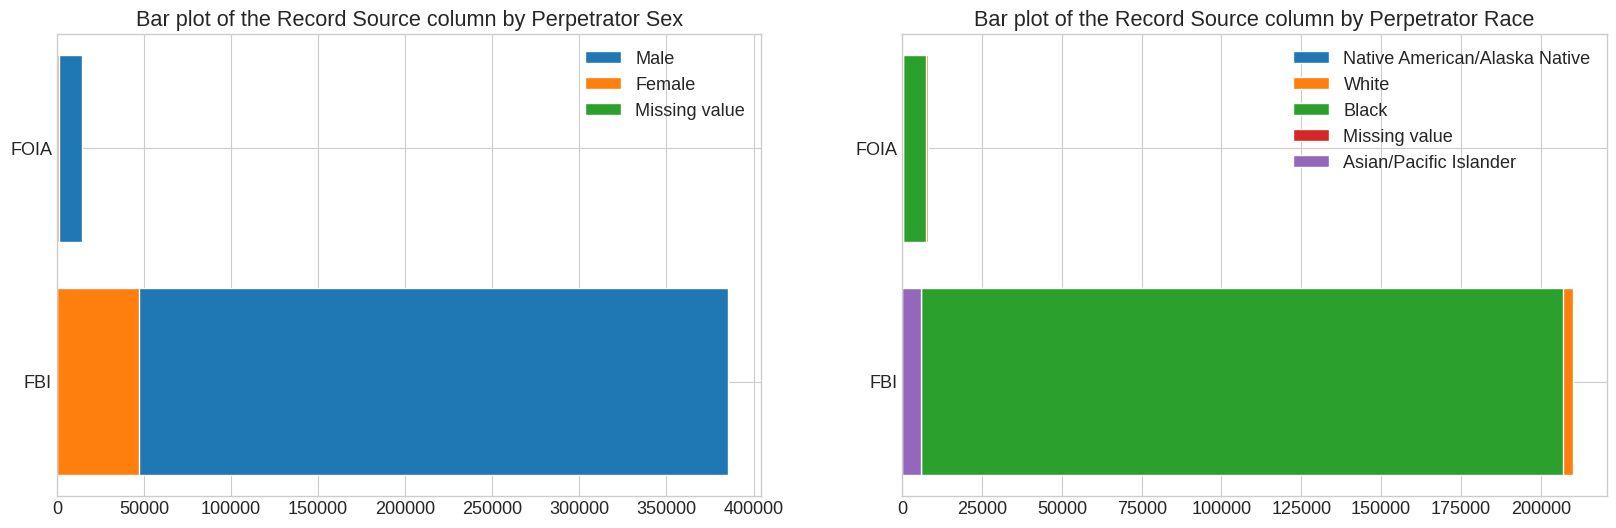

In [43]:
plot_bar(data, col='Record Source', Y_columns=Y_columns)

In [44]:
data.drop(columns_for_drop, axis=1, inplace=True)

# 9- Encoding categorical columns

In [45]:
categorical_features = cat_columns + ['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category']
categorical_features_idx = [np.where(data.columns.values == col)[0][0] for col in categorical_features]

del cat_columns

In [46]:
data_encoded = data.copy()

categorical_names = {}
encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data_encoded[feature])

    data_encoded[feature] = le.transform(data_encoded[feature])

    categorical_names[feature] = le.classes_
    encoders[feature] = le

# 10- Scale numerical columns

In [47]:
numerical_features = [c for c in data.columns.values if c not in categorical_features]

for feature in numerical_features:
    val = data_encoded[feature].values[:, np.newaxis]
    mms = MinMaxScaler().fit(val)
    data_encoded[feature] = mms.transform(val)
    encoders[feature] = mms

data_encoded = data_encoded.astype(float)

del num_columns

In [48]:
data_encoded.head()

,Agency Name,Agency Type,City,State,Year,Month,Crime Type,Victim Sex,Victim Age,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source,Perpetrator Age category
0,146.0,1.0,35.0,1.0,0.0,4.0,1.0,1.0,0.141414,3.0,1.0,1.0,15.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0
1,146.0,1.0,35.0,1.0,0.0,7.0,1.0,1.0,0.434343,4.0,1.0,1.0,42.0,4.0,0.0,14.0,0.0,0.0,0.0,0.0
3,146.0,1.0,35.0,1.0,0.0,0.0,1.0,1.0,0.434343,4.0,1.0,1.0,42.0,4.0,0.0,14.0,0.0,0.0,0.0,0.0
5,146.0,1.0,35.0,1.0,0.0,8.0,1.0,1.0,0.303030,4.0,1.0,1.0,36.0,4.0,0.0,12.0,0.0,0.0,0.0,0.0
6,146.0,1.0,35.0,1.0,0.0,8.0,1.0,0.0,0.424242,3.0,1.0,1.0,27.0,1.0,27.0,9.0,0.0,0.0,0.0,0.0


In [49]:
def decode_dataset(data, encoders, numerical_features, categorical_features):
    df = data.copy()
    for feat in df.columns.values:
        if feat in numerical_features:
            df[feat] = encoders[feat].inverse_transform(np.array(df[feat]).reshape(-1, 1))
    for feat in categorical_features:
        df[feat] = encoders[feat].inverse_transform(df[feat].astype(int))
    return df

In [50]:
decode_dataset(data_encoded, encoders=encoders, numerical_features=numerical_features,
               categorical_features=categorical_features).head()

,Agency Name,Agency Type,City,State,Year,Month,Crime Type,Victim Sex,Victim Age,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source,Perpetrator Age category
0,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,January,Murder or Manslaughter,Male,14.0,Native American/Alaska Native,Missing value,Male,15.0,Native American/Alaska Native,Acquaintance,Blunt Object,0.0,0.0,FBI,Young
1,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,March,Murder or Manslaughter,Male,43.0,White,Missing value,Male,42.0,White,Acquaintance,Strangulation,0.0,0.0,FBI,Adult
3,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,April,Murder or Manslaughter,Male,43.0,White,Missing value,Male,42.0,White,Acquaintance,Strangulation,0.0,0.0,FBI,Adult
5,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,May,Murder or Manslaughter,Male,30.0,White,Missing value,Male,36.0,White,Acquaintance,Rifle,0.0,0.0,FBI,Adult
6,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,May,Murder or Manslaughter,Female,42.0,Native American/Alaska Native,Missing value,Male,27.0,Black,Wife,Knife,0.0,0.0,FBI,Adult


# 11- AIF360

In [51]:
data_perp_sex = data_encoded.drop(['Perpetrator Race', 'Perpetrator Age category', 'Perpetrator Age'], axis=1)

In [52]:
privileged_sex = np.where(categorical_names['Victim Sex'] == 'Male')[0]
privileged_race = np.where(categorical_names['Victim Race'] == 'White')[0]

In [53]:
data_orig_sex = StandardDataset(data_perp_sex,
                                label_name='Perpetrator Sex',
                                favorable_classes=[1],
                                protected_attribute_names=['Victim Sex', 'Victim Race'],
                                privileged_classes=[privileged_sex, privileged_race])

# 12- Split into train and test set

In [54]:
np.random.seed(42)

data_orig_sex_train, data_orig_sex_test = data_orig_sex.split([0.7], shuffle=True)

display(Markdown("#### Train Dataset shape"))
print("Perpetrator Sex :", data_orig_sex_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print("Perpetrator Sex :", data_orig_sex_test.features.shape)

#### Train Dataset shape

Perpetrator Sex : (313720, 16)


#### Test Dataset shape

Perpetrator Sex : (134452, 16)


# 13- Random Forest

In [55]:
rf_orig_sex = RandomForestClassifier().fit(data_orig_sex_train.features,
                                           data_orig_sex_train.labels.ravel(),
                                           sample_weight=data_orig_sex_train.instance_weights)

In [56]:
X_test_sex = data_orig_sex_test.features
y_test_sex = data_orig_sex_test.labels.ravel()

# 14- Evaluate Model Performance

In [57]:
def get_model_performance(X_test, y_true, y_pred, probs):
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    return accuracy, matrix, f1, fpr, tpr, roc_auc


def plot_model_performance(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

    print(accuracy)
    print(f1)

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 2, 1)
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')

    ax = fig.add_subplot(1, 2, 2)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")

0.9349805134918038
0.9645513158428287


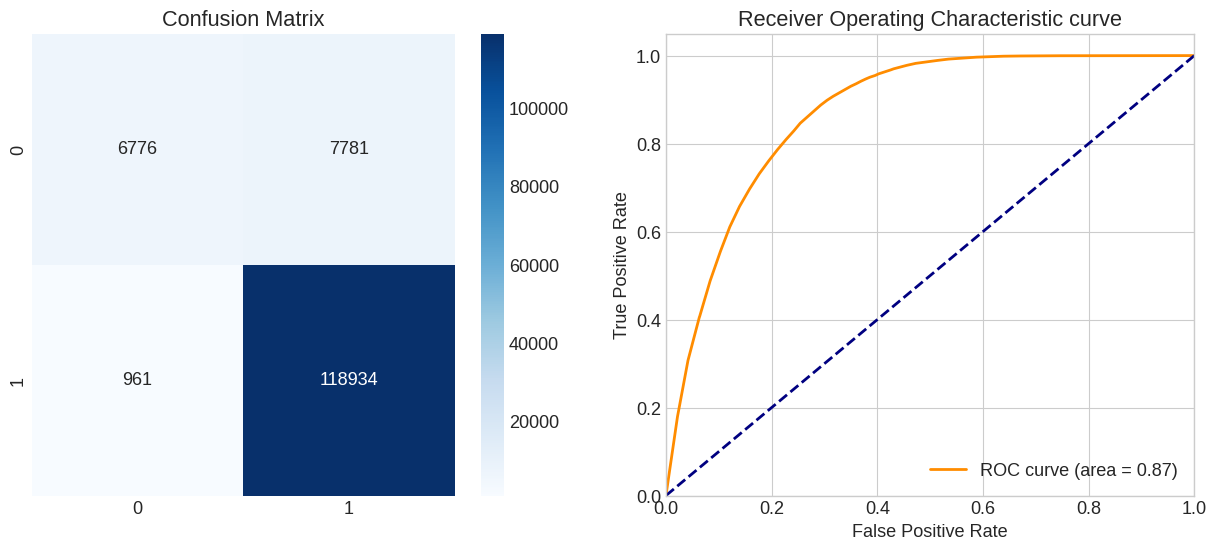

In [58]:
plot_model_performance(rf_orig_sex, data_orig_sex_test.features, y_test_sex)

# 15- Bias and Fairness

In [59]:
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])


def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]],
                                            columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

# 16- Method for Fair metrics

In [60]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred

    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',
            'disparate_impact', 'theil_index']
    obj_fairness = [[0, 0, 0, 1, 0]]

    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)

    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups = [{attr: dataset_pred.privileged_protected_attributes[idx][0]}]
        unprivileged_groups = [{attr: dataset_pred.unprivileged_protected_attributes[idx][0]}]

        classified_metric = ClassificationMetric(dataset,
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                             classified_metric.equal_opportunity_difference(),
                             classified_metric.average_abs_odds_difference(),
                             metric_pred.disparate_impact(),
                             classified_metric.theil_index()]],
                           columns=cols,
                           index=[attr]
                           )
        fair_metrics = fair_metrics.append(row)

    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)

    return fair_metrics


def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20, 4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left=0.125,
        bottom=0.1,
        right=0.9,
        top=0.9,
        wspace=.5,
        hspace=1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y=1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2, 0.2, 0.2, 0.4, 0.25]
    rect = [-0.1, -0.1, -0.1, 0.8, 0]
    bottom = [-1, -1, -1, 0, 0]
    top = [1, 1, 1, 2, 1]
    bound = [[-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1], [0.8, 1.2], [0, 0.25]]

    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0, 5)]

    for i in range(0, 5):
        plt.subplot(1, 5, i + 1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])

        for j in range(0, len(fair_metrics) - 1):
            a, val = ax.patches[j], fair_metrics.iloc[j + 1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x() + a.get_width() / 5, a.get_y() + a.get_height() + marg, round(val, 3), fontsize=15,
                    color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5, rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1,
                                       linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')
        ax.set_xlabel('')

# 16- Illustrate the fairness status before applying changes

In [61]:
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    fair = fair_metrics(data, pred)

    if plot:
        plot_fair_metrics(fair)
        display(fair)

    return fair

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
Victim Sex,0.028145,-0.006480,0.136502,1.030085,0.026875
Victim Race,0.011949,-0.000254,0.019952,1.012569,0.026875


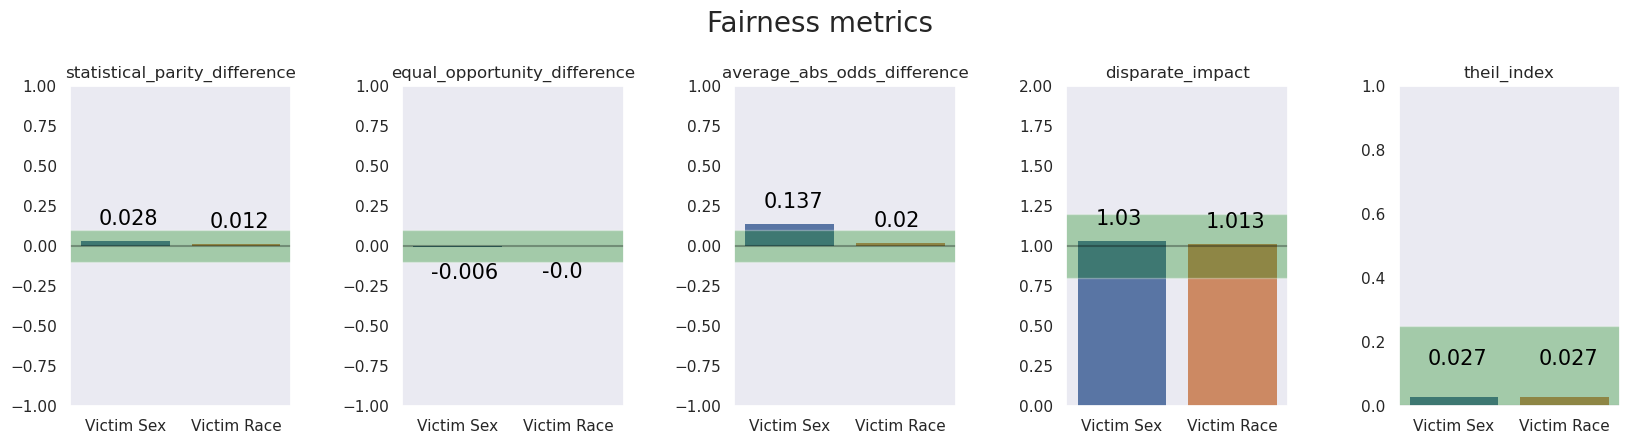

In [76]:
fair = get_fair_metrics_and_plot(data_orig_sex_test, rf_orig_sex)

In [63]:
data_orig_test = data_orig_sex_test
data_orig_train = data_orig_sex_train
rf = rf_orig_sex

probs = rf.predict_proba(data_orig_test.features)
preds = rf.predict(data_orig_test.features)
algo_metrics = add_to_df_algo_metrics(algo_metrics, rf, fair, preds, probs, 'Origin')

# 17- Dividing attribute into two parts: Privileged and Unprivileged

In [64]:
def get_attributes(data, selected_attr=None):
    unprivileged_groups = []
    privileged_groups = []
    if selected_attr == None:
        selected_attr = data.protected_attribute_names

    for attr in selected_attr:
        idx = data.protected_attribute_names.index(attr)
        privileged_groups.append({attr: data.privileged_protected_attributes[idx]})
        unprivileged_groups.append({attr: data.unprivileged_protected_attributes[idx]})

    return privileged_groups, unprivileged_groups

# Start Fixing

# Pre-processing algorithms

# 18- Learning fair representations

In [65]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
t0 = time()

LFR_model = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, k=1, verbose=0)
data_transf_train = LFR_model.fit_transform(data_orig_train)

rf_transf = RandomForestClassifier().fit(data_transf_train.features,
                                         data_transf_train.labels.ravel(),
                                         sample_weight=data_transf_train.instance_weights)

data_transf_test = LFR_model.transform(data_orig_test)
fair = get_fair_metrics_and_plot(data_transf_test, rf_transf, plot=False)
probs = rf_transf.predict_proba(data_orig_test.features)
preds = rf_transf.predict(data_orig_test.features)

algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, preds, probs, 'LFR')
print('time elapsed : %.2fs' % (time() - t0))

time elapsed : 47.35s


# 19- Reweighing

In [66]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
t0 = time()

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
# RW.fit(data_orig_train)
data_transf_train = RW.fit_transform(data_orig_train)

rf_transf = RandomForestClassifier().fit(data_transf_train.features,
                                         data_transf_train.labels.ravel(),
                                         sample_weight=data_transf_train.instance_weights)

data_transf_test = RW.transform(data_orig_test)
fair = get_fair_metrics_and_plot(data_orig_test, rf_transf, plot=False)
probs = rf_transf.predict_proba(data_orig_test.features)
preds = rf_transf.predict(data_orig_test.features)

algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, preds, probs, 'Reweighing')
print('time elapsed : %.2fs' % (time() - t0))

time elapsed : 90.48s


# In-processing algorithms

# 20- Adversarial Debiasing

In [67]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
t0 = time()

import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

sess = tf.Session()

debiased_model = AdversarialDebiasing(privileged_groups=privileged_groups,
                                      unprivileged_groups=unprivileged_groups,
                                      scope_name='debiased_classifier',
                                      num_epochs=10,
                                      debias=True,
                                      sess=sess)

debiased_model.fit(data_orig_train)

fair = get_fair_metrics_and_plot(data_orig_test, debiased_model, plot=False, model_aif=True)
data_pred = debiased_model.predict(data_orig_test)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores,
                                      'AdvDebiasing')
print('time elapsed : %.2fs' % (time() - t0))

Instructions for updating:
non-resource variables are not supported in the long term
2022-12-19 23:52:20.659441: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-19 23:52:20.659496: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-19 23:52:20.659528: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-12-19 23:52:20.660718: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler

epoch 0; iter: 0; batch classifier loss: 426.382233; batch adversarial loss: 0.725854
epoch 0; iter: 200; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 400; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 600; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 800; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 1000; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 1200; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 1400; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 1600; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 1800; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 2000; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 2200; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 2400; batch classifier loss: nan; batch adversarial loss

# 21- Prejudice Remover Regularizer

In [68]:
t0 = time()
debiased_model = PrejudiceRemover(sensitive_attr="Victim Race", eta=25.0)
debiased_model.fit(data_orig_train)

fair = get_fair_metrics_and_plot(data_orig_test, debiased_model, plot=False, model_aif=True)
data_pred = debiased_model.predict(data_orig_test)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores,
                                      'PrejudiceRemover')
print('time elapsed : %.2fs' % (time() - t0))

time elapsed : 844.36s


#  Post-processing algorithms

In [69]:
data_orig_test_pred = data_orig_test.copy(deepcopy=True)

scores = np.zeros_like(data_orig_test.labels)
scores = rf.predict_proba(data_orig_test.features)[:, 1].reshape(-1, 1)
data_orig_test_pred.scores = scores

preds = np.zeros_like(data_orig_test.labels)
preds = rf.predict(data_orig_test.features).reshape(-1, 1)
data_orig_test_pred.labels = preds


def format_probs(probs1):
    probs1 = np.array(probs1)
    probs0 = np.array(1 - probs1)
    return np.concatenate((probs0, probs1), axis=1)

# 22- Calibrated Equality of Odds

In [70]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
t0 = time()

cost_constraint = "fnr"  # "fnr", "fpr", "weighted"

CPP = CalibratedEqOddsPostprocessing(privileged_groups=privileged_groups,
                                     unprivileged_groups=unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=42)

CPP = CPP.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = CPP.predict(data_orig_test_pred)

fair = fair_metrics(data_orig_test, data_orig_test_pred, pred_is_dataset=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics,
                                      CPP,
                                      fair,
                                      data_transf_test_pred.labels,
                                      format_probs(data_transf_test_pred.scores),
                                      'CalibratedEqOdds')
print('time elapsed : %.2fs' % (time() - t0))

time elapsed : 1.68s


# 23- Comparison Section

In [71]:
def plot_fair_metrics_plotly(fair_metrics):
    bottom = [-1, -1, -1, 0, 0]
    max_valid = [0.1, 0.1, 0.1, 1.2, 0.25]
    min_valid = [-0.1, -0.1, -0.1, 0.8, 0]
    cols = fair_metrics.columns.values

    for i in range(0, 5):
        col = cols[i]

        x, y = (fair_metrics[col].values, fair_metrics.index)
        colors = []
        for v in x:
            color = '#e74c3c' if v < min_valid[i] or v > max_valid[i] else '#2ecc71'
            colors.append(color)

        trace = go.Bar(x=x, y=y, marker=dict(color=colors)
                       , opacity=0.9, orientation='h')

        layout = go.Layout(barmode='group',
                           title=col,
                           xaxis=dict(range=[bottom[i], bottom[i] + 2]),
                           yaxis=go.layout.YAxis(automargin=True),
                           shapes=[
                               {
                                   'type': 'line',
                                   'x0': min_valid[i],
                                   'y0': -1,
                                   'x1': min_valid[i],
                                   'y1': len(y),
                                   'line': {
                                       'color': 'rgb(0, 0, 0)',
                                       'width': 2,
                                   },
                               }, {
                                   'type': 'line',
                                   'x0': max_valid[i],
                                   'y0': -1,
                                   'x1': max_valid[i],
                                   'y1': len(y),
                                   'line': {
                                       'color': 'rgb(0, 0, 0)',
                                       'width': 2,
                                   },
                               }])
        fig = go.Figure([trace], layout=layout)
        py.iplot(fig)


def plot_score_fair_metrics(score):
    display(score.sort_values(['nb_valid', 'score'], ascending=[0, 1]))
    score.sort_values(['nb_valid', 'score'], ascending=[1, 0], inplace=True)

    gold, silver, bronze, other = ('#FFA400', '#bdc3c7', '#cd7f32', '#3498db')
    colors = [gold if i == 0 else silver if i == 1 else bronze if i == 2 else other for i in range(0, len(score))]
    colors = [c for c in reversed(colors)]

    x, y = (score['score'].values, score.index)

    trace = go.Bar(x=x, y=y, marker=dict(color=colors)
                   , opacity=0.9, orientation='h')
    layout = go.Layout(barmode='group',
                       title='Fairest algorithm',
                       yaxis=go.layout.YAxis(automargin=True))
    fig = go.Figure([trace], layout=layout)
    py.iplot(fig)


def score_fair_metrics(fair):
    objective = [0, 0, 0, 1, 0]
    max_valid = [0.1, 0.1, 0.1, 1.2, 0.25]
    min_valid = [-0.1, -0.1, -0.1, 0.8, 0]

    nb_valid = np.sum(((fair.values > min_valid) * (fair.values < max_valid)), axis=1)
    score = np.sum(np.abs(fair.values - objective), axis=1)
    score = np.array([score, nb_valid])

    score = pd.DataFrame(data=score.transpose(), columns=['score', 'nb_valid'], index=fair.index)
    return score


def score_all_attr(algo_metrics):
    attributes = algo_metrics.loc['Origin', 'fair_metrics'].index.values[1:]

    all_scores = np.zeros((len(algo_metrics), 2))
    for attr in attributes:
        df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin', 'fair_metrics'].columns.values)
        for fair in algo_metrics.loc[:, 'fair_metrics']:
            df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)
        all_scores = all_scores + score_fair_metrics(df_metrics).values

    final = pd.DataFrame(data=all_scores, columns=['score', 'nb_valid'], index=algo_metrics.index)
    return final


In [84]:
def compare_fair_metrics_Race(algo_metrics, attr='Victim Race'):
    df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin', 'fair_metrics'].columns.values)
    for fair in algo_metrics.loc[:, 'fair_metrics']:
        df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)

    df_metrics.index = algo_metrics.index.values
    df_metrics = df_metrics.replace([np.inf, -np.inf], np.NaN)

    display(df_metrics)
    plot_fair_metrics_plotly(df_metrics)
    score = score_fair_metrics(df_metrics)
    plot_score_fair_metrics(score.dropna())

In [85]:
compare_fair_metrics_Race(algo_metrics)

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
Origin,0.011949,-0.000254,0.019952,1.012569,0.026875
LFR,0.000000,0.000000,NaN,1.000000,0.000000
Reweighing,0.010689,-0.001109,0.016643,1.011251,0.026891
AdvDebiasing,0.000000,0.000000,0.000000,NaN,2.223135
PrejudiceRemover,0.000000,0.000000,0.000000,1.000000,0.032631
CalibratedEqOdds,0.011949,-0.000254,0.019952,1.012569,0.026875


,score,nb_valid
PrejudiceRemover,0.032631,5.0
Reweighing,0.066582,5.0
Origin,0.071599,5.0
CalibratedEqOdds,0.071599,5.0


In [88]:
def compare_fair_metrics_Sex(algo_metrics, attr='Victim Sex'):
    df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin', 'fair_metrics'].columns.values)
    for fair in algo_metrics.loc[:, 'fair_metrics']:
        df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)

    df_metrics.index = algo_metrics.index.values
    df_metrics = df_metrics.replace([np.inf, -np.inf], np.NaN)

    display(df_metrics)
    plot_fair_metrics_plotly(df_metrics)
    score = score_fair_metrics(df_metrics)
    plot_score_fair_metrics(score.dropna())

In [89]:
compare_fair_metrics_Sex(algo_metrics)

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
Origin,0.028145,-0.006480,0.136502,1.030085,0.026875
LFR,0.000000,0.000000,NaN,1.000000,0.000000
Reweighing,0.027796,-0.006826,0.136261,1.029722,0.026891
AdvDebiasing,0.000000,0.000000,0.000000,NaN,2.223135
PrejudiceRemover,0.000000,0.000000,0.000000,1.000000,0.032631
CalibratedEqOdds,0.028145,-0.006480,0.136502,1.030085,0.026875


,score,nb_valid
PrejudiceRemover,0.032631,5.0
Reweighing,0.227496,4.0
Origin,0.228087,4.0
CalibratedEqOdds,0.228087,4.0


In [86]:
def plot_compare_model_performance(algo_metrics, dataset):
    X_test = dataset.features
    y_true = dataset.labels
    perf_metrics = pd.DataFrame()

    models_name = algo_metrics.index.values

    fig = plt.figure(figsize=(7, 7))
    plt.title('ROC curve for differents models')
    lw = 2
    palette = sns.color_palette("Paired")

    for model_name, i in zip(models_name, range(0, len(models_name))):
        model = algo_metrics.loc[model_name, 'model']

        if model_name != 'AdvDebiasing' and model_name != 'LFR' and model_name != 'PrejudiceRemover':
            print(model_name)
            probs = algo_metrics.loc[model_name, 'probs']
            y_pred = algo_metrics.loc[model_name, 'prediction']
            accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

            perf_metrics = perf_metrics.append(
                pd.DataFrame([[accuracy, f1,fpr]], columns=['Accuracy', 'F1 Score','fpr'], index=[model_name]))
            plt.plot(fpr, tpr, color=palette[i], lw=lw, label=str(model_name) + ' (area = %0.2f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")
    display(perf_metrics.sort_values(by=['Accuracy', 'F1 Score'], ascending=[False, False]))
    plt.show()

Origin
Reweighing
CalibratedEqOdds


,Accuracy,F1 Score,fpr
Reweighing,0.935181,0.964653,"[0.0, 0.021158205674246068, 0.0211582056742460..."
Origin,0.934981,0.964551,"[0.0, 0.021570378512056055, 0.0215703785120560..."
CalibratedEqOdds,0.552889,0.678662,"[0.0, 0.009273888850724736, 0.0092738888507247..."


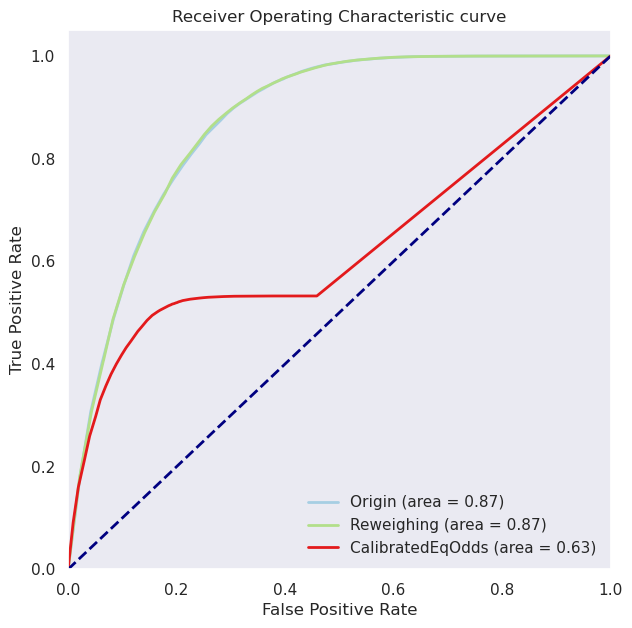

In [87]:
plot_compare_model_performance(algo_metrics, data_orig_test)